In [1]:
!pip install pytorch-ignite

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.7/296.7 kB 5.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from ignite.engine import Engine, Events
from ignite.metrics import Loss, Accuracy
from ignite.contrib.handlers.tqdm_logger import ProgressBar
import matplotlib.pyplot as plt

<ipython-input-2-d852632026ca>:8: DeprecationWarning: /usr/local/lib/python3.10/dist-packages/ignite/contrib/handlers/tqdm_logger.py has been moved to /ignite/handlers/tqdm_logger.py and will be removed in version 0.6.0.
 Please refer to the documentation for more details.
  from ignite.contrib.handlers.tqdm_logger import ProgressBar


In [3]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

100%|██████████| 26421880/26421880 [00:09<00:00, 2769874.66it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 136967.61it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 2724221.71it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 21399679.87it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [4]:
print(f"Number of training samples: {len(training_data)}")
print(f"Number of testing samples: {len(test_data)}")

Number of training samples: 60000
Number of testing samples: 10000


In [5]:
print(f"Number of training samples: {len(training_data)}")
print(f"Number of testing samples: {len(test_data)}")

Number of training samples: 60000
Number of testing samples: 10000


In [6]:
print("Shape of each sample: ", training_data[0][0].shape)
print("Label for 0th sample: ", training_data[0][1])

Shape of each sample:  torch.Size([1, 28, 28])
Label for 0th sample:  9


In [7]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

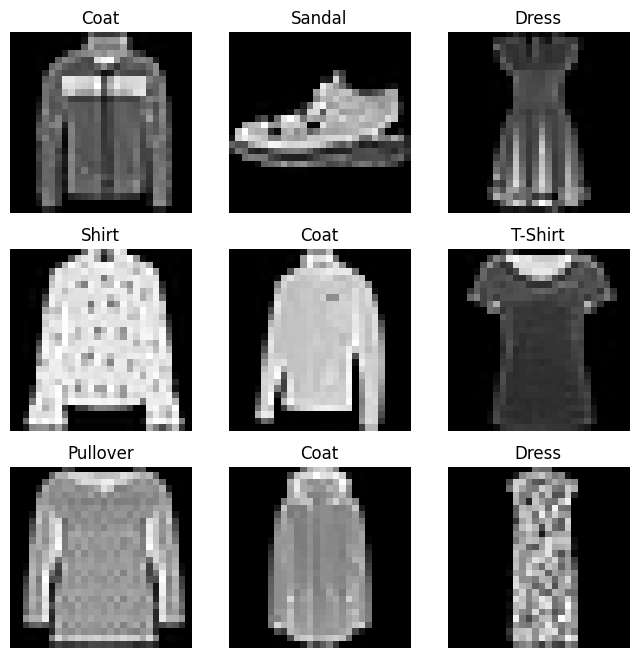

In [8]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [9]:
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

In [10]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Training batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Training batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


In [11]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [12]:
device = ("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda device


In [13]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [14]:
# Setting hyperparameters
learning_rate = 1e-3
batch_size = 64
epochs = 5

In [15]:
# Initialize loss function, and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [16]:
# Define training step function
def train_step(engine, batch):
    model.train()
    optimizer.zero_grad()
    x, y = batch
    x = x.to(device)
    y = y.to(device)
    y_pred = model(x)
    loss = loss_fn(y_pred, y)
    loss.backward()
    optimizer.step()
    return loss.item()

In [17]:
# Define evaluation function
def eval_step(engine, batch):
    model.eval()
    with torch.no_grad():
        x, y = batch
        x = x.to(device)
        y = y.to(device)
        y_pred = model(x)
        return y_pred, y

In [18]:
# Define Ignite engine
trainer = Engine(train_step)

# Define evaluators for training and validation
train_evaluator = Engine(eval_step)
val_evaluator = Engine(eval_step)

In [19]:
# Attach metrics
Loss(loss_fn).attach(train_evaluator, "loss")
Accuracy().attach(train_evaluator, "accuracy")
Loss(loss_fn).attach(val_evaluator, "loss")
Accuracy().attach(val_evaluator, "accuracy")

In [20]:
# Logging training loss and validation loss
train_loss_values = []
val_loss_values = []
val_accuracy_values = []

In [21]:
ProgressBar().attach(trainer, output_transform=lambda x: {"batch loss": x})
ProgressBar().attach(train_evaluator)
ProgressBar().attach(val_evaluator)

In [22]:
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(engine):
    train_evaluator.run(train_dataloader)
    metrics = train_evaluator.state.metrics
    train_loss = metrics['loss']
    train_accuracy = metrics['accuracy']
    print(f"Training - Epoch: {engine.state.epoch}  Avg loss: {train_loss:.2f} Avg accuracy: {train_accuracy:.2f}")

    # Append training metrics for plotting
    train_loss_values.append(train_loss)

In [23]:
@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(engine):
    val_evaluator.run(test_dataloader)
    metrics = val_evaluator.state.metrics
    val_loss = metrics['loss']
    val_accuracy = metrics['accuracy']
    print(f"Validation - Epoch: {engine.state.epoch}  Avg loss: {val_loss:.2f} Avg accuracy: {val_accuracy:.2f}")

    # Append validation metrics for plotting
    val_loss_values.append(val_loss)
    val_accuracy_values.append(val_accuracy)

In [24]:
# Run training
val_interval = 1
trainer.run(train_dataloader, max_epochs=epochs)

[1/938]   0%|           [00:00<?]

[1/938]   0%|           [00:00<?]

Training - Epoch: 1  Avg loss: 2.17 Avg accuracy: 0.37


[1/157]   1%|           [00:00<?]

Validation - Epoch: 1  Avg loss: 2.17 Avg accuracy: 0.36


[1/938]   0%|           [00:00<?]

[1/938]   0%|           [00:00<?]

Training - Epoch: 2  Avg loss: 1.91 Avg accuracy: 0.54


[1/157]   1%|           [00:00<?]

Validation - Epoch: 2  Avg loss: 1.91 Avg accuracy: 0.54


[1/938]   0%|           [00:00<?]

[1/938]   0%|           [00:00<?]

Training - Epoch: 3  Avg loss: 1.53 Avg accuracy: 0.59


[1/157]   1%|           [00:00<?]

Validation - Epoch: 3  Avg loss: 1.54 Avg accuracy: 0.59


[1/938]   0%|           [00:00<?]

[1/938]   0%|           [00:00<?]

Training - Epoch: 4  Avg loss: 1.26 Avg accuracy: 0.64


[1/157]   1%|           [00:00<?]

Validation - Epoch: 4  Avg loss: 1.27 Avg accuracy: 0.63


[1/938]   0%|           [00:00<?]

[1/938]   0%|           [00:00<?]

Training - Epoch: 5  Avg loss: 1.10 Avg accuracy: 0.65


[1/157]   1%|           [00:00<?]

Validation - Epoch: 5  Avg loss: 1.10 Avg accuracy: 0.64


State:
	iteration: 4690
	epoch: 5
	epoch_length: 938
	max_epochs: 5
	output: 0.9992887377738953
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

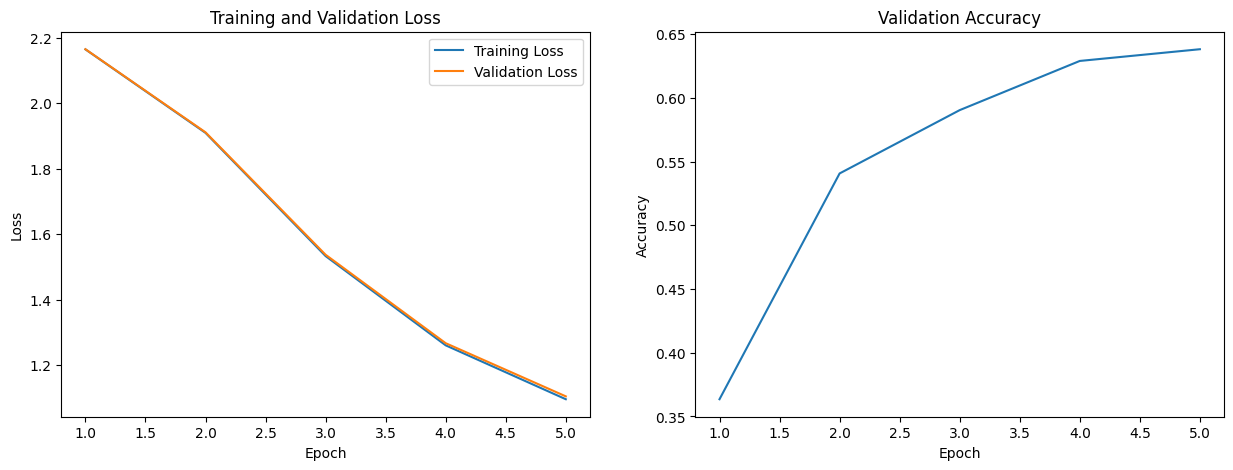

In [25]:
plt.figure(figsize=(15, 5))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_loss_values, label="Training Loss")
plt.plot(range(val_interval, epochs + 1, val_interval), val_loss_values, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

# Plot validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(val_interval, epochs + 1, val_interval), val_accuracy_values)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy")

plt.show()

In [26]:
torch.save(model, "model.pth")

In [27]:
model = torch.load("model.pth")

In [28]:
checkpoint = {
    "model_state": model.state_dict(),
    "optimizer_state": optimizer.state_dict(),
    "train_loss": train_loss_values,
    "val_loss": val_loss_values,
    "val_accuracy": val_accuracy_values
}
torch.save(checkpoint, 'checkpoint.pth.tar')

In [29]:
# Loading the checkpoint
checkpoint = torch.load("checkpoint.pth.tar")

# First load the model architecture i.e. instantiate the model class and optimizer
model = NeuralNetwork()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# Then load the model weights and optimizer state
model.load_state_dict(checkpoint['model_state'])
optimizer.load_state_dict(checkpoint['optimizer_state'])

# We can use these values for plotting
train_loss_values = checkpoint['train_loss']
val_loss_values = checkpoint['val_loss']
val_accuracy_values = checkpoint['val_accuracy']

In [30]:
image, label = test_data[0]
print("Image shape: ", image.shape)
# Adding batch dimension
image_reshaped = image.unsqueeze(0).to(device)
model = model.to(device)
print("Image shape after unsqueeze: ", image_reshaped.shape)
prediction = model(image_reshaped)
prediction_index = prediction.argmax().item()
print(f'Predicted: {prediction_index}')
print(f'Target: {label}')

Image shape:  torch.Size([1, 28, 28])
Image shape after unsqueeze:  torch.Size([1, 1, 28, 28])
Predicted: 9
Target: 9


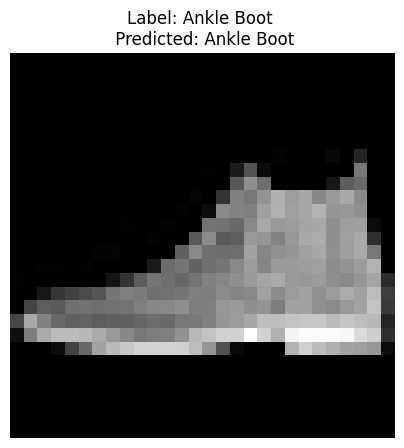

In [31]:
figure = plt.figure(figsize=(5, 5))
plt.title(f"Label: {labels_map[label]} \n Predicted: {labels_map[prediction_index]}")
plt.imshow(image.squeeze(), cmap="gray")
plt.xlabel(labels_map[prediction_index])
plt.axis("off")
plt.show()

In [32]:
model = NeuralNetwork()
model.load_state_dict(checkpoint['model_state'])
quantized_model = torch.quantization.quantize_dynamic(model, {torch.nn.Linear}, dtype=torch.qint8)
print(quantized_model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): DynamicQuantizedLinear(in_features=784, out_features=512, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
    (1): ReLU()
    (2): DynamicQuantizedLinear(in_features=512, out_features=512, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
    (3): ReLU()
    (4): DynamicQuantizedLinear(in_features=512, out_features=10, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
  )
)


In [33]:
torch.save(quantized_model, "quantized_model.pth")

In [34]:
!pip install onnxruntime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 50.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 14.6 MB/s eta 0:00:00


In [35]:
!pip install onnx
loaded_model = torch.load("quantized_model.pth")
dummy_input = torch.randn(1, 1, 28, 28).to(device)
torch.onnx.export(model.to(device), dummy_input, "quantized_model.onnx")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 64.5 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/torch/_utils.py:382: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  device=storage.device,


In [36]:
import onnxruntime as ort
import numpy as np

EP_list = ['CPUExecutionProvider']
ort_sess = ort.InferenceSession("quantized_model.onnx", providers=EP_list)
input_name = ort_sess.get_inputs()[0].name

image, label = test_data[0]
input_data = np.expand_dims(image, axis=0)
outputs = ort_sess.run(None, {input_name: input_data})[0]
prediction_index = outputs.argmax().item()
print("Label: ", label)
print("Predicted: ", prediction_index)

Label:  9
Predicted:  9
